# How to wait for user input using `interrupt`

!!! tip "Prerequisites"

    This guide assumes familiarity with the following concepts:

    * [Human-in-the-loop](../../../concepts/human_in_the_loop)
    * [LangGraph Glossary](../../../concepts/low_level)
    

**Human-in-the-loop (HIL)** interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). Waiting for human input is a common HIL interaction pattern, allowing the agent to ask the user clarifying questions and await input before proceeding. 

We can implement this in LangGraph using the [`interrupt()`][langgraph.types.interrupt] function. `interrupt` allows us to stop graph execution to collect input from a user and continue execution with collected input.

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic and / or OpenAI (the LLM(s) we will use)

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Simple Usage

Let's explore a basic example of using human feedback. A straightforward approach is to create a node, **`human_feedback`**, designed specifically to collect user input. This allows us to gather feedback at a specific, chosen point in our graph.

Steps:

1. **Call `interrupt()`** inside the **`human_feedback`** node.  
2. **Set up a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)** to save the graph's state up to this node.  
3. **Use `Command(resume=...)`** to provide the requested value to the **`human_feedback`** node and resume execution.

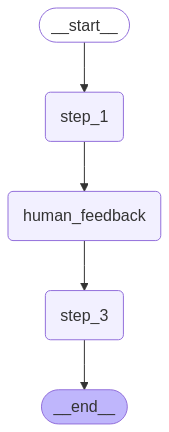

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# highlight-next-line
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    # highlight-next-line
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Run until our `interrupt()` at `human_feedback`:

In [4]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:c723d73a-d2cb-32cf-452f-e147367868bd']),)}




Now, we can manually update our graph state with the user input:

In [5]:
# Continue the graph execution
for event in graph.stream(
    # highlight-next-line
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




We can see our feedback was added to state - 

In [6]:
graph.get_state(thread).values

{'input': 'hello world', 'user_feedback': 'go to step 3!'}

## Agent

In the context of [agents](../../../concepts/agentic_concepts), waiting for user feedback is especially useful for asking clarifying questions. To illustrate this, we’ll create a simple [ReAct-style agent](../../../concepts/agentic_concepts#react-implementation) capable of [tool calling](https://python.langchain.com/docs/concepts/tool_calling/). 

For this example, we’ll use Anthropic's chat model along with a **mock tool** (purely for demonstration purposes).

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>  

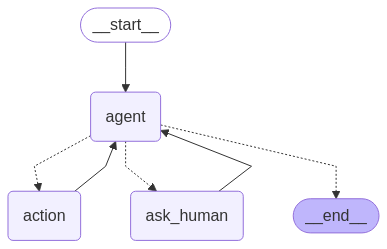

In [7]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)

# Set up the model
from langchain_anthropic import ChatAnthropic

model = ChatAnthropic(model="claude-3-5-sonnet-latest")

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    # highlight-next-line
    location = interrupt(ask.question)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    path_map=["ask_human", "action", END],
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

## Interacting with the Agent

We can now interact with the agent. Let's ask it to ask the user where they are, then tell them the weather. 

This should make it use the `ask_human` tool first, then use the normal tool.

In [8]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "Ask the user where they are, then look up the weather there",
            )
        ]
    },
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ask the user where they are, then look up the weather there
================================== Ai Message ==================================

[{'text': "I'll help you with that. Let me first ask the user about their location.", 'type': 'text'}, {'id': 'toolu_012Z9yyZjvH8xKgMShgwpQZ9', 'input': {'question': 'Where are you located?'}, 'name': 'AskHuman', 'type': 'tool_use'}]
Tool Calls:
  AskHuman (toolu_012Z9yyZjvH8xKgMShgwpQZ9)
 Call ID: toolu_012Z9yyZjvH8xKgMShgwpQZ9
  Args:
    question: Where are you located?


In [9]:
app.get_state(config).next

('ask_human',)

You can see that our graph got interrupted inside the `ask_human` node, which is now waiting for a `location` to be provided. We can provide this value by invoking the graph with a `Command(resume="<location>")` input:

In [10]:
for event in app.stream(
    # highlight-next-line
    Command(resume="san francisco"),
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help you with that. Let me first ask the user about their location.", 'type': 'text'}, {'id': 'toolu_012Z9yyZjvH8xKgMShgwpQZ9', 'input': {'question': 'Where are you located?'}, 'name': 'AskHuman', 'type': 'tool_use'}]
Tool Calls:
  AskHuman (toolu_012Z9yyZjvH8xKgMShgwpQZ9)
 Call ID: toolu_012Z9yyZjvH8xKgMShgwpQZ9
  Args:
    question: Where are you located?
================================= Tool Message =================================

san francisco
================================== Ai Message ==================================

[{'text': "Now I'll search for the weather in San Francisco.", 'type': 'text'}, {'id': 'toolu_01QrWBCDouvBuJPZa4veepLw', 'input': {'query': 'current weather in san francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_01QrWBCDouvBuJPZa4veepLw)
 Call ID: toolu_01QrWBCDouvBuJPZa4veepLw
  Args:
    query: current weather in san francisco
=